# Breast cancer case

In [80]:
import numpy as np
import pandas as pd
import feyn

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

from _crossvalidation import crossvalidation_as_framework

### Load and prep data

In [2]:
data = pd.read_csv('../data/brca_data_w_meta.csv')

In [3]:
# Define the target variable
target = "vital.status"

In [4]:
stypes = {}
for f in data.columns:
    if data[f].dtype == 'object':
        stypes[f] = 'c'

### 2 feature models

In [77]:
results = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 50,
                                     criterion='bic',
                                     max_complexity = 3)

In [78]:
results.groupby("fold").first().roc_auc_val.mean(), results.roc_auc_val.mean()

(0.6474232139502873, 0.6386899509202167)

In [79]:
for model in results.groupby("fold").first().model_structure:
    print(model)

logreg(exp(-rsFOLR1**2 - rsTNMD**2))
logreg(exp(-rsAPOB**2 - rsPOF1B**2))
logreg(exp(-rsACVR1C**2 - rsFLJ45983**2))
logreg(exp(-rsKCNIP2**2 - rsOXTR**2))
logreg(rsAPOB*rsSLC13A2)


#### Exploration of best models

In [94]:
best_models_qstrings = ['exp(squared("rs_FOLR1") +  squared("rs_TNMD"))',
                        'exp(squared("rs_APOB") +   squared("rs_POF1B"))',
                        'exp(squared("rs_ACVR1C") + squared("rs_FLJ45983"))',
                        'exp(squared("rs_KCNIP2") + squared("rs_OXTR"))',
                        '"rs_APOB"*"rs_SLC13A2"']
n_folds = 5
random_state = 42
models_trained = []
train_list = []
val_list = []

kfold_test = StratifiedKFold(n_folds, shuffle=True, random_state=random_state)
for i, (train, val) in enumerate(kfold_test.split(data, data[target])):
        train, val = data.iloc[train], data.iloc[val]
        train_list.append(train)
        val_list.append(val)
        
        sample_weights = np.where(train[target] == 1,
                                      np.sum(train[target] == 0) / sum(train[target]), 1)
        
        model = ql.auto_run(train, output_name=target, n_epochs=20, kind = "classification",
                             query_string=best_models_qstrings[i], sample_weights=sample_weights, stypes=stypes)[0]
        models_trained.append(model)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="216.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 621 216.0" width="621" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="351" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="50.0"><title>vital.status
logistic:
w=-0.9636
bias=-0.3888</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">vital.st..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="243" y="59.0">out</text><line stroke="#1E1E1E" x1="211" x2="241" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="50.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="71.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="59.0">1</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>rs_APOB
linear:
scale=0.149502
scale offset=2.288630
w=-2.278790
bias=-0.5084</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">rs_APOB</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>rs_SLC13A2
linear:
scale=0.165339
scale offset=4.554204
w=1.051868
bias=0.1707</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">rs_SLC13..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text></svg><svg class="summary" height="79" width="180" x="351" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Training Metrics</text><line stroke="#1E1E1E" x1="0" x2="160" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="34">Accuracy</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="34">0.81</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="49">AUC</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="49">0.669</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="64">Precision</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="64">0.33</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="79">Recall</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="79">0.413</text></svg><svg class="summary" height="79" width="90" x="531" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="star
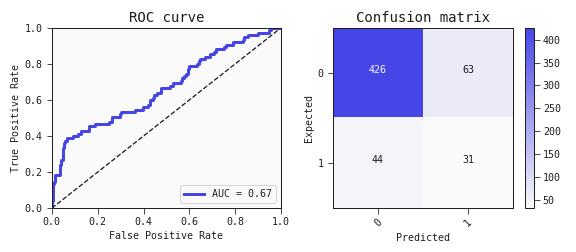
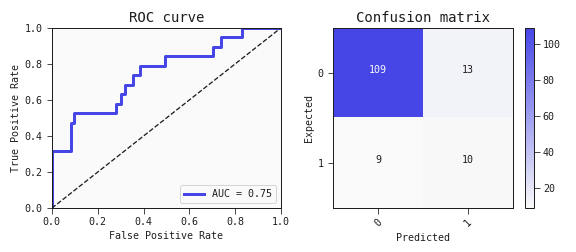

In [106]:
models_trained[-1].plot(train_list[-1], val_list[-1])

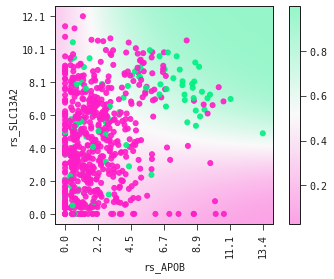

In [105]:
models_trained[-1].plot_response_2d(data)

### Larger models (default options)

In [18]:
results100 = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 100,
                                     criterion='bic')

In [22]:
results.groupby("fold").first().roc_auc_val.mean(), results.roc_auc_val.mean()

(0.6183480214152156, 0.6313666034560834)

In [19]:
for model in results100.groupby("fold").first().model_structure:
    print(model)

logreg(rsPTCHD1*(cnADAMTS16 + muDMD + rsFABP4 + rsSOX2))
logreg(rsAPOB*(cnPRODH*(cnCOL14A1 + ppPI3K.p110.alpha) + rsTAT))
logreg(cnCLCA2 + rsSLC13A2*(cnSLC30A8 + rsAPOB + rsPAX7))
logreg(rsTCN1*(ppp27 + rsDEFB132*rsPTPRZ1 + rsSOX2))
logreg(cnTNFRSF11B + ppMSH6**2 + rsCYP4Z2P + rsPCOLCE2 + rsPLA2G2D)


### Comparison with random forest

In [83]:
df = pd.get_dummies(data)


parameters={'bootstrap': [True, False],
             'ccp_alpha': [0.0],
             'class_weight': ['balanced'],
             'max_depth': [3, 4, 5],
             'max_features': ['auto', 'sqrt'],
             'max_leaf_nodes': [None],
             'max_samples': [None],
             'min_impurity_decrease': [0.0],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [5, 10, 15],
             'min_weight_fraction_leaf': [0.0],
             'n_estimators': [50, 75, 100],
             'random_state': [42]
                }

rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, verbose=1, n_jobs=-1, scoring='roc_auc')
clf.fit(df.drop(columns=target), df[target])

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'ccp_alpha': [0.0],
                         'class_weight': ['balanced'], 'max_depth': [3, 4, 5],
                         'max_features': ['auto', 'sqrt'],
                         'max_leaf_nodes': [None], 'max_samples': [None],
                         'min_impurity_decrease': [0.0],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10, 15],
                         'min_weight_fraction_leaf': [0.0],
                         'n_estimators': [50, 75, 100], 'random_state': [42]},
             scoring='roc_auc', verbose=1)

In [84]:
clf.best_params_

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'random_state': 42}

In [85]:
clf.best_score_

0.6587626937529081